<a href="https://colab.research.google.com/github/foxtrotmike/CS909/blob/master/fourier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# If Fourier knew about neural networks...
by [Fayyaz Minhas](https://sites.google.com/view/fayyaz/home?authuser=0)

Imagine that Fourier has just had his epiphany telling him that a given signal can be decmoposed into sum of sines and cosines of different frequencies. The coefficients of the sines and cosines determine their relative contribution to the signal. However, how would he determine these coefficients? In this imaginary Fourier world, let's imagine he knew about neural network or more precisely about the Representation-Evaluation-Optimization approaoch and programming in an automatic differentiation library. How could he have done it instead?

This tutorial explores how Fourier transform can be viewed as a neural network. By treating the decomposition and reconstruction of signals as a learning process, we employ a special neural network model architecture to approximate the discrete Fourier Transform (DFT), enabling the analysis and synthesis of signals in terms of their sinusoidal components.

## Representation

We consider a decomposition based view of the Fourier transform. Assume we are given a signal $x[m],m=0,...,N-1$ which can be represented by an N-dimensional row vector $x$. We would like to decompose the signal into sinusoids as follows:

$$\hat{x}[m;W]=\frac{1}{N}\sum_{k=0}^{N-1} A_k^{cos}(x;W)cos(2\pi m k/N)+ A_k^{sin}(x;W)sin(2\pi m k/N)$$
Here, $A_k^{cos}(x;W)$ and $A_k^{cos}(x;W)$ are the coefficients of the cosine and sine terms in our decomposition. Assume further that each of these coefficients can be generated by a neural network with a single linear layer of unknown weight parameters $W$ as:

$$A_k^{cos}(x;W) = xW_k^{real}$$
$$A_k^{sin}(x;W) = xW_k^{imag}$$

Here, $W=[W^{real} | W^{imag}]$ is be the $N\times 2N$ unknown parameter matrix which consists of two $N\times N$sub-matrices ($W^{real}$ and $W^{real}$) appended coloum-wise. The rows of these matrices correspond to time steps and columns  to frequencies (e.g., $W_k^{real}$ vector corresponds to the $k^{th}$ frequency) such that when these matrices are multiplied with the signal, we can get the cosine and sine components.

Fortunately, all of this can be implemented in a simple neural network that takes in a signal and generates its sine and cosine coefficients using linear layer weights (without bias) as submatrices. The following code implements such a model. The output generated by the model is then simply multiplied by sines and cosines and averaged to generate the reconstruction.

Specifically, we will see if we can indeed learn to prodice Fourier Coefficients for a given signal.

## Evaluation

The above decomposition can be achieved by minimization of the following loss function:

$$l(W;x)=\frac{1}{N} \sum_m (x[m]-\hat{x}[m;W])^2$$

We take a many (random) signals to obtain the optimal parameter matrix $W$ by solving the following optimization problem:

$$W^* = argmin_W \sum_x l(W;x)$$

## Optimization

We can optimize using gadient descent. In this code, we use the adaptive momemntum based optimizer.

## Testing

Once the neural network has been trained, it can be used to generate the fourier domain representation of any given signal.

### important note:

This implementation is meant for developing a conceptural understanding rather than practical Fourier decomposition of signals for which you can use: [torch.fft](https://pytorch.org/blog/the-torch.fft-module-accelerated-fast-fourier-transforms-with-autograd-in-pyTorch/) which, despite being implemented in pytorch, is a non-neural but fast implementation of fourier transform.


In [1]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

class FourierNet(nn.Module):
    def __init__(self, N):
        super(FourierNet, self).__init__()
        # Initialize linear layers for real and imaginary parts without bias
        self.N = N
        self.tvals = torch.arange(N).view(-1, 1).float().to(device)  # Reshape and convert to float for division
        self.freqs = torch.arange(N).view(1, -1).float().to(device)  # Reshape and convert to float for division
        self.tf = 2 * torch.pi * self.tvals * self.freqs / N  # tf_(j,k) = 2*pi*(t_j)*(f_k) = 2pi(j)(k)/N (matrix of size NxN)
        self.cos_vals = torch.cos(self.tf) #cosines
        self.sin_vals = torch.sin(self.tf) #sines
        self.linear_real = nn.Linear(N, N, bias=False)
        self.linear_imag = nn.Linear(N, N, bias=False)
    def forward(self, x):
        # Use the linear layers to compute y_real and y_imag
        # performs fourier decomposition
        y_real = self.linear_real(x)
        y_imag = self.linear_imag(x)
        return y_real, y_imag
    def reconstruct(self,x):
        # takes a signal, first decomposes it and then reconstructs it
        y_real, y_imag = self.forward(x)
        sinusoids = y_real * self.cos_vals + y_imag * self.sin_vals
        reconstructed_signal = (1/N)*torch.sum(sinusoids, axis=1)
        return reconstructed_signal
    def AmplitudePhaseRepresentation(self,x): #ignore in first reading
        y_real, y_imag = self.forward(x)
        amplitudes = torch.sqrt(y_real**2 + y_imag**2) #A_k = sqrt((x*W^{imag}_k)**2+(x*W^{real}_k)**2) amplitude of the k-th sinusoid
        phases = torch.atan2(y_imag, y_real) # \phi_k = atan2(x*W^{imag}_k,x*W^{real}_k) phase of the k-th sinusoid
        sinusoids = amplitudes * torch.sin(self.tf + phases)
        return amplitudes,phases,sinusoids

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
N = 100
fnet = FourierNet(N)
optimizer = torch.optim.SGD(fnet.parameters(), lr=0.5)
losses = []
for i in tqdm(range(5000)):
    optimizer.zero_grad()
    x = (torch.rand(1, N)).to(device) #take a signal
    xhat = fnet.reconstruct(x)
    loss = torch.sum((x - xhat) ** 2)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())



100%|██████████| 5000/5000 [00:10<00:00, 476.49it/s]


Ratio of parameters used in the model to the ones used in Fourier: 1.0


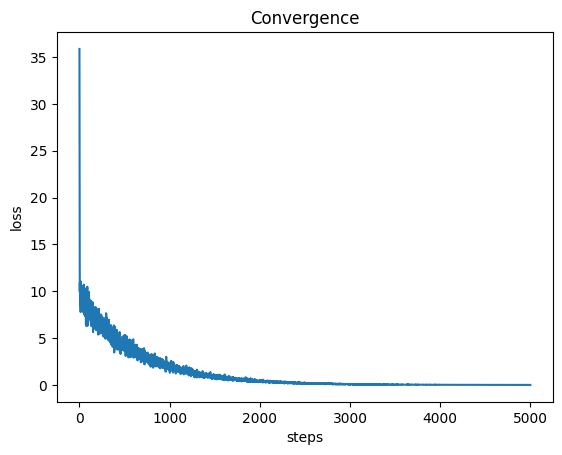

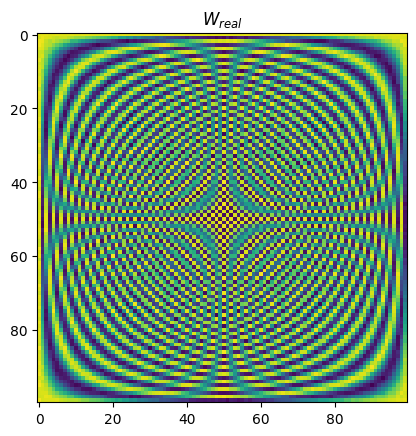

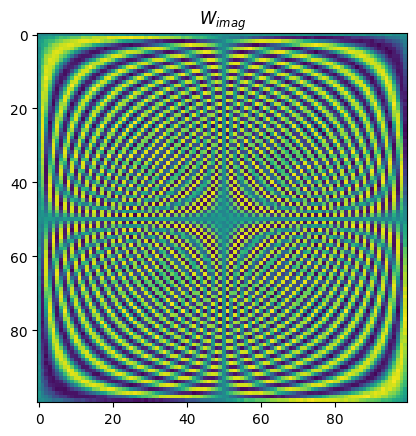

In [2]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = count_parameters(fnet)
print(f"Ratio of parameters used in the model to the ones used in Fourier: {total_params/(N*N*2)}")
import matplotlib.pyplot as plt
plt.plot(losses);plt.xlabel('steps');plt.ylabel('loss');plt.title('Convergence');plt.show()
W_real = fnet.linear_real.weight
W_imag = fnet.linear_imag.weight
Wr = W_real.detach().cpu().numpy()
Wi = W_imag.detach().cpu().numpy()
plt.imshow(Wr);plt.title('$W_{real}$');plt.show()
plt.imshow(Wi);plt.title('$W_{imag}$');plt.show()

Notice that the learned Fourier matrices are very close the [DFT Matrices](https://en.wikipedia.org/wiki/DFT_matrix).

We have thus learned the underlying basis matrices that can be used to decompose any function!

# Testing

Let's see if it is able to generate the Fourier transform of a test signal:

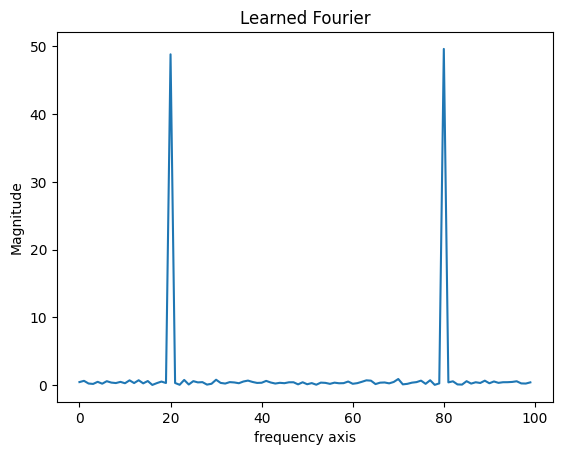

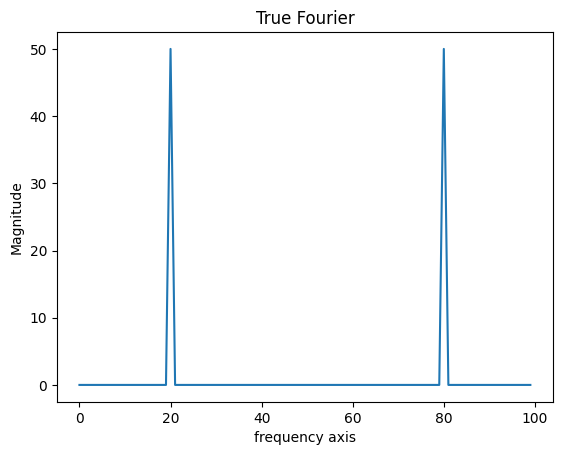

In [3]:
with torch.no_grad():
  t = torch.arange(N).to(device)
  x = torch.cos(2*torch.pi*0.2*t)
  M,P,_ = fnet.AmplitudePhaseRepresentation(x)
  plt.plot(M.detach().cpu().numpy()); plt.xlabel('frequency axis'); plt.ylabel('Magnitude'); plt.title('Learned Fourier');plt.show()
  plt.plot(torch.abs(torch.fft.fft(x))); plt.xlabel('frequency axis'); plt.ylabel('Magnitude'); plt.title('True Fourier');plt.show()

## Advanced: Low-rank approximation of the Fourier matrix

We can also build lower-rank approximation of this matrix.


## Amplitude-Phase Decomposition Representation (optional)

An alternate representation is the amplitude-phase decomposition which can also be used:

$$\hat{x}[m;W]=\frac{1}{N}\sum_{k=0}^{N-1} A_k(x;W)sin(2\pi m k/N+\phi_k(x;W))$$


Here, $A_k(x;W)$ is the magnitude of the k-th frequency sinusoid and $\phi_k(x;W)$ is its phase. Naturally, the amplitude and phase are dependent upon the signal and we would like to recover them. For this purpose, we represent:

$$A_k(x;W)=\sqrt {(xW^{real}_k)^2+(xW^{imag}_k)^2}$$
$$\phi_k(x;W)=arctan(xW^{imag}_k,xW^{real}_k)$$

It is very easy to update the code to use this representation instead.